# emotion-classifier 0.2

In [18]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [19]:
# !unzip "gdrive/MyDrive/datasets/challenges-in-representation-learning-facial-expression-recognition-challenge.zip" -d 'datasets'

In [20]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from typing import Tuple

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras

from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

!pip install git+https://github.com/tensorflow/docs

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

!pip install mlxtend --upgrade --no-deps
import mlxtend                                                      
print(mlxtend.__version__) 

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ax2cz7lo
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-ax2cz7lo
  Resolved https://github.com/tensorflow/docs to commit c1510dc5ad73aa829249822798e6263360b0f62a
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
0.21.0


In [21]:
root_dir = '/content/datasets/'
full_data_file_name = 'icml_face_data.csv'
train_data_file_name = 'train.csv'
test_data_file_name = 'test.csv'

In [22]:
def prepare_data(data: pd.core.frame.DataFrame) -> Tuple[np.array, np.array]:
  image_array = np.zeros(shape=(len(data), 48, 48, 1))
  image_label = np.array(list(map(int, data['emotion'])))

  for i, row in enumerate(data.index):
    image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
    image = np.reshape(image, (48, 48))
    image_array[i, :, :, 0] = image / 255.0

  return image_array, image_label


def reshape_and_scale(data: np.array) -> np.array:
  data = data.reshape((data.shape[0], 48, 48, 1))
  data = data.astype('float32') / 255.0

  return data

In [23]:
df = pd.read_csv(root_dir + full_data_file_name)
df.columns = ('emotion', 'Usage', 'pixels')
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [30]:
#split data into training, validation and test set
data_train = df[df['Usage']=='Training'].copy()
data_val   = df[df['Usage']=='PublicTest'].copy()
data_test  = df[df['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))



train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [31]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = keras.utils.to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


In [32]:
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

model = Sequential()


#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 46, 46, 256)       2560      
                                                                 
 batch_normalization_9 (Batc  (None, 46, 46, 256)      1024      
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 46, 46, 256)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_10 (Bat  (None, 46, 46, 256)      1024      
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 46, 46, 256)      

In [33]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=1, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/50


<ipython-input-33-0e66acf67115>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),


448/448 [==============================] - 57s 115ms/step - loss: 1.7189 - accuracy: 0.3142 - val_loss: 1.8319 - val_accuracy: 0.3068
Epoch 2/50
448/448 [==============================] - 52s 115ms/step - loss: 1.4315 - accuracy: 0.4452 - val_loss: 1.4226 - val_accuracy: 0.4564
Epoch 3/50
448/448 [==============================] - 52s 116ms/step - loss: 1.2737 - accuracy: 0.5120 - val_loss: 1.2966 - val_accuracy: 0.5060
Epoch 4/50
448/448 [==============================] - 51s 113ms/step - loss: 1.1984 - accuracy: 0.5422 - val_loss: 1.1452 - val_accuracy: 0.5609
Epoch 5/50
448/448 [==============================] - 51s 115ms/step - loss: 1.1383 - accuracy: 0.5667 - val_loss: 1.3877 - val_accuracy: 0.4762
Epoch 6/50
448/448 [==============================] - 53s 118ms/step - loss: 1.0971 - accuracy: 0.5826 - val_loss: 1.2120 - val_accuracy: 0.5531
Epoch 7/50
448/448 [==============================] - 51s 113ms/step - loss: 1.0628 - accuracy: 0.6005 - val_loss: 1.0996 - val_accuracy: 0.5

In [34]:
test_loss, test_acc = model.evaluate(test_X, test_Y)
test_acc

113/113 [==============================] - 2s 17ms/step - loss: 0.9568 - accuracy: 0.6523


0.6522708535194397

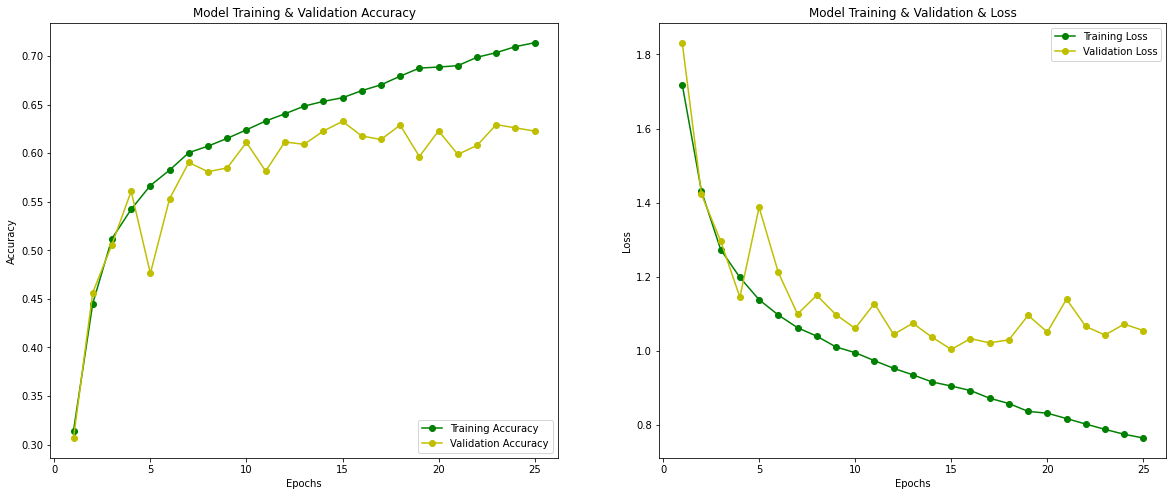

In [36]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [37]:
model.save('model')
model.save('modelh5', save_format='h5')
# model = keras.models.load_model("model")

In [38]:
#make prediction
test_y = np.argmax(test_Y, axis=1)
test_yhat = np.argmax(model.predict(test_X), axis=1)

113/113 [==============================] - 2s 17ms/step


In [39]:
!pip install mlxtend --upgrade --no-deps

import mlxtend
                                                          
print(mlxtend.__version__) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
0.21.0


[[224   5  59  30  75   9  89]
 [ 17  22   6   3   2   3   2]
 [ 46   4 216  36  89  56  81]
 [  8   0  10 816  23  10  12]
 [ 25   5  63  39 307   7 148]
 [  6   2  47  28   7 303  23]
 [  7   0  21  64  77   4 453]]


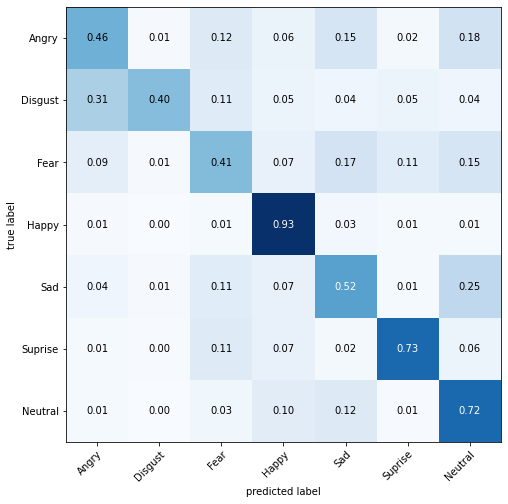

In [40]:
emotions = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Suprise',
    6: 'Neutral'
}

#get confusion matrix
cm = confusion_matrix(test_y, test_yhat)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

In [41]:
!zip -r /content/model_02.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/saved_model.pb (deflated 90%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 74%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model/keras_metadata.pb (deflated 95%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/fingerprint.pb (stored 0%)
